In [1]:
# Global color palette configuration for the notebook
WEGO_COLORS = {
    'navy': '#14213D',        # deep navy blue
    'purple': '#5E4AE3',      # rich purple accent
    'green': '#39FF14',       # terminal-inspired neon green
    'orange': '#E76F51',      # burnt orange accent
    'charcoal': '#1E1E24',    # dark neutral for backgrounds
    'slate': '#6C757D'        # muted text accent
}

PLOTLY_CONTINUOUS = [
    [0.0, WEGO_COLORS['purple']],
    [0.5, WEGO_COLORS['orange']],
    [1.0, WEGO_COLORS['green']]
]

PLOTLY_SEQUENTIAL = [
    [0.0, WEGO_COLORS['purple']],
    [0.4, WEGO_COLORS['navy']],
    [1.0, WEGO_COLORS['green']]
]

WEGO_HEATMAP_CMAP = LinearSegmentedColormap.from_list(
    'wego_heatmap',
    [WEGO_COLORS['purple'], WEGO_COLORS['navy'], WEGO_COLORS['green']]
)

sns.set_palette([WEGO_COLORS['green'], WEGO_COLORS['orange'], WEGO_COLORS['purple']])
plt.rcParams['axes.titlecolor'] = WEGO_COLORS['navy']
plt.rcParams['axes.labelcolor'] = WEGO_COLORS['slate']
plt.rcParams['text.color'] = WEGO_COLORS['slate']

NameError: name 'LinearSegmentedColormap' is not defined

In [ ]:
# Run all cells to display visualizations (without saving)
# This will show all the figures inline in the notebook

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create output directories
os.makedirs('output/tables', exist_ok=True)
os.makedirs('output/images', exist_ok=True)
os.makedirs('output/pdf', exist_ok=True)

pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid')

# Load data
wego = pd.read_csv('data/Headway Data, 8-1-2023 to 9-30-2023.csv')
print(f"Loaded dataset with shape: {wego.shape}")

# Calculate overall performance
ontime = wego['ADJUSTED_ONTIME_COUNT'].sum()
early = wego['ADJUSTED_EARLY_COUNT'].sum()
late = wego['ADJUSTED_LATE_COUNT'].sum()
total = ontime + early + late

print(f"\n=== Overall Performance ===")
print(f"On-Time: {(ontime/total)*100:.2f}%")
print(f"Early: {(early/total)*100:.2f}%")
print(f"Late: {(late/total)*100:.2f}%")

Loaded dataset with shape: (350329, 30)

=== Overall Performance ===
On-Time: 79.69%
Early: 2.88%
Late: 17.42%


In [ ]:
# 1. GAUGE CHART - Overall Performance
fig = go.Figure(go.Indicator(
    mode="gauge+number+delta",
    value=(ontime/total)*100,
    delta={'reference': 80, 'suffix': '%', 'increasing': {'color': WEGO_COLORS['green']}, 'decreasing': {'color': WEGO_COLORS['orange']}},
    title={'text': "System On-Time Performance (%)", 'font': {'color': WEGO_COLORS['navy']}},
    gauge={
        'axis': {'range': [0, 100], 'tickcolor': WEGO_COLORS['slate']},
        'bar': {'color': WEGO_COLORS['green']},
        'steps': [
            {'range': [0, 70], 'color': WEGO_COLORS['purple']},
            {'range': [70, 80], 'color': WEGO_COLORS['orange']},
            {'range': [80, 100], 'color': WEGO_COLORS['green']}
        ],
        'threshold': {
            'line': {'color': WEGO_COLORS['navy'], 'width': 4},
            'thickness': 0.75,
            'value': 80
        }
    }
))
fig.update_layout(
    height=500,
    width=600,
    margin={'t': 50, 'b': 20, 'l': 20, 'r': 20},
    font={'size': 14, 'color': WEGO_COLORS['slate']},
    title="Slide 2: Overall Performance Gauge",
    paper_bgcolor='white'
)
fig.show()

In [ ]:
# 3. TREEMAP - Operator Performance
operator = wego.groupby('OPERATOR').agg({
    'ADJUSTED_ONTIME_COUNT':'sum',
    'ADJUSTED_EARLY_COUNT':'sum',
    'ADJUSTED_LATE_COUNT':'sum'
}).reset_index()
operator['Total'] = operator[['ADJUSTED_ONTIME_COUNT','ADJUSTED_EARLY_COUNT','ADJUSTED_LATE_COUNT']].sum(axis=1)
operator['OnTime_Pct'] = (operator['ADJUSTED_ONTIME_COUNT'] / operator['Total'])*100
operator_top = operator.nlargest(100, 'Total')

fig = px.treemap(
    operator_top,
    path=['OPERATOR'],
    values='Total',
    color='OnTime_Pct',
    color_continuous_scale=PLOTLY_CONTINUOUS,
    title='Slide 4: Operator Performance (Top 100 by Volume)'
)
fig.update_layout(
    margin={'t':40,'l':0,'r':0,'b':0},
    coloraxis_colorbar=dict(title='On-Time %', tickcolor=WEGO_COLORS['slate'], titlefont=dict(color=WEGO_COLORS['slate']))
)
fig.show()

In [ ]:
# 4. PERFORMANCE TREND - Refined Time-Series Layout
def hex_to_rgba(hex_color: str, alpha: float = 0.25) -> str:
    hex_color = hex_color.lstrip('#')
    r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
    return f'rgba({r}, {g}, {b}, {alpha})'

# Aggregate performance by service day
daily = wego.groupby('DATE').agg({
    'ADJUSTED_ONTIME_COUNT': 'sum',
    'ADJUSTED_EARLY_COUNT': 'sum',
    'ADJUSTED_LATE_COUNT': 'sum'
}).reset_index()

daily['DATE'] = pd.to_datetime(daily['DATE'])
daily = daily.sort_values('DATE')

daily['Total'] = daily[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT']].sum(axis=1)
daily['OnTime_Pct'] = daily['ADJUSTED_ONTIME_COUNT'] / daily['Total'] * 100

daily['OnTime_7D'] = daily['OnTime_Pct'].rolling(window=7, min_periods=4).mean()
daily['OnTime_14D'] = daily['OnTime_Pct'].rolling(window=14, min_periods=7).mean()

dip_points = daily[daily['OnTime_Pct'] < 75]

fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.08,
    row_heights=[0.72, 0.28]
)

# Confidence band between 14-day average and 7-day average
fig.add_trace(
    go.Scatter(
        x=pd.concat([daily['DATE'], daily['DATE'][::-1]]),
        y=pd.concat([daily['OnTime_7D'].fillna(method='bfill'), daily['OnTime_14D'].fillna(method='bfill')[::-1]]),
        fill='toself',
        fillcolor=hex_to_rgba(WEGO_COLORS['purple'], 0.1),
        line=dict(color='rgba(0,0,0,0)'),
        hoverinfo='skip',
        showlegend=False
    ),
    row=1,
    col=1
)

# Daily on-time line
fig.add_trace(
    go.Scatter(
        x=daily['DATE'],
        y=daily['OnTime_Pct'],
        mode='lines',
        line=dict(color=WEGO_COLORS['navy'], width=3),
        name='On-Time % (Daily)',
        hovertemplate='Date: %{x|%b %d, %Y}<br>On-Time %: %{y:.1f}%<extra></extra>'
    ),
    row=1,
    col=1
)

# Rolling averages for trend context
fig.add_trace(
    go.Scatter(
        x=daily['DATE'],
        y=daily['OnTime_7D'],
        mode='lines',
        line=dict(color=WEGO_COLORS['green'], width=2, dash='dash'),
        name='On-Time % (7-Day Avg)',
        hovertemplate='Date: %{x|%b %d, %Y}<br>7-Day Avg: %{y:.1f}%<extra></extra>'
    ),
    row=1,
    col=1
)
fig.add_trace(
    go.Scatter(
        x=daily['DATE'],
        y=daily['OnTime_14D'],
        mode='lines',
        line=dict(color=WEGO_COLORS['slate'], width=2, dash='dot'),
        name='On-Time % (14-Day Avg)',
        hovertemplate='Date: %{x|%b %d, %Y}<br>14-Day Avg: %{y:.1f}%<extra></extra>'
    ),
    row=1,
    col=1
)

# Highlight low-performance dips
if not dip_points.empty:
    fig.add_trace(
        go.Scatter(
            x=dip_points['DATE'],
            y=dip_points['OnTime_Pct'],
            mode='markers',
            marker=dict(size=6, color=WEGO_COLORS['orange'], line=dict(color='white', width=1)),
            name='Below 75%',
            hovertemplate='Date: %{x|%b %d, %Y}<br>On-Time %: %{y:.1f}%<extra></extra>'
        ),
        row=1,
        col=1
    )

# Trip volume subplot
fig.add_trace(
    go.Bar(
        x=daily['DATE'],
        y=daily['Total'],
        name='Trip Volume',
        marker=dict(color=hex_to_rgba(WEGO_COLORS['purple'], 0.6), line=dict(color=WEGO_COLORS['purple'], width=0.4)),
        hovertemplate='Date: %{x|%b %d, %Y}<br>Total Trips: %{y:,}<extra></extra>'
    ),
    row=2,
    col=1
)

fig.add_hline(y=80, line=dict(color=WEGO_COLORS['orange'], width=1.5, dash='dot'), row=1, col=1)
fig.add_hrect(y0=80, y1=100, fillcolor=hex_to_rgba(WEGO_COLORS['green'], 0.08), line_width=0, row=1, col=1)

fig.update_yaxes(
    title_text='On-Time Performance (%)',
    range=[60, 100],
    tickfont=dict(color=WEGO_COLORS['slate']),
    gridcolor=hex_to_rgba(WEGO_COLORS['slate'], 0.25),
    row=1,
    col=1
)
fig.update_yaxes(
    title_text='Total Trips',
    tickfont=dict(color=WEGO_COLORS['slate']),
    gridcolor=hex_to_rgba(WEGO_COLORS['slate'], 0.1),
    row=2,
    col=1
)

fig.update_xaxes(
    tickfont=dict(color=WEGO_COLORS['slate']),
    gridcolor=hex_to_rgba(WEGO_COLORS['slate'], 0.1),
    row=2,
    col=1,
    rangeslider=dict(visible=True, bgcolor=hex_to_rgba(WEGO_COLORS['navy'], 0.05)),
    rangeselector=dict(
        y=1.2,
        x=0,
        buttons=[
            dict(count=14, label='2W', step='day', stepmode='backward'),
            dict(count=1, label='1M', step='month', stepmode='backward'),
            dict(count=2, label='2M', step='month', stepmode='backward'),
            dict(step='all')
        ]
    )
)

fig.update_layout(
    title='Slide 5: Performance Trend Over Time',
    legend=dict(
        orientation='v',
        x=1.02,
        y=1,
        yanchor='top',
        xanchor='left',
        bgcolor=hex_to_rgba(WEGO_COLORS['navy'], 0.05),
        borderwidth=0,
        font=dict(color=WEGO_COLORS['slate'])
    ),
    hovermode='x unified',
    margin=dict(t=70, l=40, r=150, b=90),
    paper_bgcolor='white',
    plot_bgcolor='white',
    font=dict(color=WEGO_COLORS['slate'])
)

fig.show()
if SAVE_PDF:
    save_plotly_figure(fig, 'performance_trend_over_time')

C:\Users\user\AppData\Local\Temp\ipykernel_3096\192590027.py:37: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [ ]:
# 6. BUBBLE CHART - Route Performance
route = wego.groupby('ROUTE_ABBR').agg({
    'ADJUSTED_ONTIME_COUNT':'sum',
    'ADJUSTED_EARLY_COUNT':'sum',
    'ADJUSTED_LATE_COUNT':'sum',
    'HDWY_DEV':'mean'
}).reset_index()
route['Total'] = route[['ADJUSTED_ONTIME_COUNT','ADJUSTED_EARLY_COUNT','ADJUSTED_LATE_COUNT']].sum(axis=1)
route['OnTime_Pct'] = (route['ADJUSTED_ONTIME_COUNT']/route['Total'])*100

fig = px.scatter(
    route,
    x='OnTime_Pct',
    y='HDWY_DEV',
    size='Total',
    color='OnTime_Pct',
    hover_name='ROUTE_ABBR',
    color_continuous_scale=PLOTLY_CONTINUOUS,
    title='Slide 7: Route Performance Bubble Chart'
)
fig.update_layout(
    xaxis_title='On-Time %',
    yaxis_title='Mean Headway Deviation (min)',
    coloraxis_colorbar=dict(title='On-Time %', tickcolor=WEGO_COLORS['slate'], titlefont=dict(color=WEGO_COLORS['slate']))
)
fig.show()

In [ ]:
# 9. SUNBURST - Hierarchical Performance Breakdown
sunburst_data = []

for route in wego['ROUTE_ABBR'].unique():
    route_df = wego[wego['ROUTE_ABBR'] == route]

    for direction in route_df['ROUTE_DIRECTION_NAME'].unique():
        dir_df = route_df[route_df['ROUTE_DIRECTION_NAME'] == direction]

        ontime_sum = dir_df['ADJUSTED_ONTIME_COUNT'].sum()
        early_sum = dir_df['ADJUSTED_EARLY_COUNT'].sum()
        late_sum = dir_df['ADJUSTED_LATE_COUNT'].sum()

        if ontime_sum > 0:
            sunburst_data.append({
                'route': str(route),
                'direction': direction,
                'outcome': 'On-Time',
                'count': ontime_sum
            })
        if early_sum > 0:
            sunburst_data.append({
                'route': str(route),
                'direction': direction,
                'outcome': 'Early',
                'count': early_sum
            })
        if late_sum > 0:
            sunburst_data.append({
                'route': str(route),
                'direction': direction,
                'outcome': 'Late',
                'count': late_sum
            })

sunburst_df = pd.DataFrame(sunburst_data)

color_map = {
    'On-Time': WEGO_COLORS['green'],
    'Early': WEGO_COLORS['orange'],
    'Late': WEGO_COLORS['purple']
}

fig = px.sunburst(
    sunburst_df,
    path=['route', 'direction', 'outcome'],
    values='count',
    color='outcome',
    color_discrete_map=color_map,
    title='Slide 10: Hierarchical Performance Breakdown'
)
fig.update_layout(
    width=900,
    height=700,
    paper_bgcolor='white',
    margin=dict(t=80, l=20, r=20, b=20),
    font=dict(color=WEGO_COLORS['slate']),
    legend=dict(
        title='Outcome',
        font=dict(color=WEGO_COLORS['slate']),
        bgcolor=hex_to_rgba(WEGO_COLORS['navy'], 0.05) if 'hex_to_rgba' in globals() else None
    )
)
fig.show()
if SAVE_PDF:
    save_plotly_figure(fig, 'sunburst_hierarchy')

In [ ]:
# 11. WATERFALL CHART - Performance Breakdown
total_trips = wego['ADJUSTED_ONTIME_COUNT'].sum() + wego['ADJUSTED_EARLY_COUNT'].sum() + wego['ADJUSTED_LATE_COUNT'].sum()
ontime_base = wego['ADJUSTED_ONTIME_COUNT'].sum()
early_impact = wego['ADJUSTED_EARLY_COUNT'].sum()
late_impact = wego['ADJUSTED_LATE_COUNT'].sum()

waterfall_data = {
    'Category': ['Total Trips', 'On-Time', 'Early Departures', 'Late Arrivals', 'Final Performance'],
    'Value': [total_trips, ontime_base, -early_impact, -late_impact, ontime_base],
    'Measure': ['absolute', 'relative', 'relative', 'relative', 'total']
}

waterfall_df = pd.DataFrame(waterfall_data)

fig = go.Figure(go.Waterfall(
    name="Performance",
    orientation="v",
    measure=waterfall_df['Measure'],
    x=waterfall_df['Category'],
    y=waterfall_df['Value'],
    text=[f"{v:,.0f}" for v in waterfall_df['Value']],
    textposition="outside",
    connector={"line": {"color": "rgb(63, 63, 63)"}},
    increasing={"marker": {"color": "#2ECC71"}},
    decreasing={"marker": {"color": "#E74C3C"}},
    totals={"marker": {"color": "#3498DB"}}
))

fig.update_layout(
    title="Slide 12: Performance Waterfall Analysis",
    showlegend=False,
    width=1000,
    height=600,
    yaxis_title="Number of Trips"
)
fig.show()

In [ ]:
# 12. KEY FINDINGS & RECOMMENDATIONS
wego_summary = wego.copy()
wego_summary['DATE'] = pd.to_datetime(wego_summary['DATE'])
if 'DAY_OF_WEEK' not in wego_summary.columns:
    wego_summary['DAY_OF_WEEK'] = wego_summary['DATE'].dt.day_name()

# Overall performance
total_ontime_sum = wego_summary['ADJUSTED_ONTIME_COUNT'].sum()
total_early_sum = wego_summary['ADJUSTED_EARLY_COUNT'].sum()
total_late_sum = wego_summary['ADJUSTED_LATE_COUNT'].sum()
total_sum = total_ontime_sum + total_early_sum + total_late_sum
overall_on_time_pct = (total_ontime_sum / total_sum * 100) if total_sum else 0

# Route performance
route_perf = (
    wego_summary.groupby('ROUTE_ABBR')
    .agg({
        'ADJUSTED_ONTIME_COUNT': 'sum',
        'ADJUSTED_EARLY_COUNT': 'sum',
        'ADJUSTED_LATE_COUNT': 'sum'
    })
)
route_perf['Total'] = route_perf.sum(axis=1)
route_perf['OnTime_Pct'] = (route_perf['ADJUSTED_ONTIME_COUNT'] / route_perf['Total'] * 100).replace([np.inf, -np.inf], np.nan)
route_perf = route_perf.dropna(subset=['OnTime_Pct'])

best_route = route_perf['OnTime_Pct'].idxmax() if not route_perf.empty else 'N/A'
worst_route = route_perf['OnTime_Pct'].idxmin() if not route_perf.empty else 'N/A'
best_route_pct = route_perf.loc[best_route, 'OnTime_Pct'] if best_route in route_perf.index else np.nan
worst_route_pct = route_perf.loc[worst_route, 'OnTime_Pct'] if worst_route in route_perf.index else np.nan

# Day-of-week performance
day_perf = (
    wego_summary.groupby('DAY_OF_WEEK')
    .agg({
        'ADJUSTED_ONTIME_COUNT': 'sum',
        'ADJUSTED_EARLY_COUNT': 'sum',
        'ADJUSTED_LATE_COUNT': 'sum'
    })
)
day_perf['Total'] = day_perf.sum(axis=1)
day_perf['OnTime_Pct'] = (day_perf['ADJUSTED_ONTIME_COUNT'] / day_perf['Total'] * 100).replace([np.inf, -np.inf], np.nan)
day_perf = day_perf.dropna(subset=['OnTime_Pct'])

best_day = day_perf['OnTime_Pct'].idxmax() if not day_perf.empty else 'N/A'
worst_day = day_perf['OnTime_Pct'].idxmin() if not day_perf.empty else 'N/A'

# Operator performance range
operator_perf = (
    wego_summary.groupby('OPERATOR')
    .agg({
        'ADJUSTED_ONTIME_COUNT': 'sum',
        'ADJUSTED_EARLY_COUNT': 'sum',
        'ADJUSTED_LATE_COUNT': 'sum'
    })
)
operator_perf['Total'] = operator_perf.sum(axis=1)
operator_perf['OnTime_Pct'] = (operator_perf['ADJUSTED_ONTIME_COUNT'] / operator_perf['Total'] * 100).replace([np.inf, -np.inf], np.nan)
operator_perf = operator_perf.dropna(subset=['OnTime_Pct'])
op_perf_filtered = operator_perf[operator_perf['Total'] >= 50]['OnTime_Pct']

operator_min = op_perf_filtered.min() if not op_perf_filtered.empty else np.nan
operator_max = op_perf_filtered.max() if not op_perf_filtered.empty else np.nan

# Correlation insight
corr_value = wego_summary[['ADHERENCE', 'HDWY_DEV']].corr().iloc[0, 1] if {'ADHERENCE', 'HDWY_DEV'}.issubset(wego_summary.columns) else np.nan

# Compose findings and recommendations text
findings = [
    f"• Overall on-time performance sits at {overall_on_time_pct:.1f}% across {int(total_sum):,} trips.",
    f"• Route spread ranges from {best_route} at {best_route_pct:.1f}% to {worst_route} at {worst_route_pct:.1f}% on-time." if not np.isnan(best_route_pct) else "• Route performance shows meaningful variability across the network.",
    f"• Late departures account for {(total_late_sum/total_sum*100):.1f}% of trips; early departures contribute {(total_early_sum/total_sum*100):.1f}%." if total_sum else "• Late and early departures remain a measurable portion of total trips.",
    f"• {best_day} leads weekly reliability while {worst_day} lags, signalling targeted scheduling opportunities." if best_day != 'N/A' and worst_day != 'N/A' else "• Day-of-week patterns indicate peaks in reliability and stress periods worth deeper review.",
    f"• Operator reliability spans {operator_min:.1f}%–{operator_max:.1f}% for those with 50+ trips." if not np.isnan(operator_min) else "• High-volume operators exhibit varied reliability levels, suggesting room for coaching.",
    f"• Adherence vs. headway deviation correlation: {corr_value:.2f}, reinforcing schedule control initiatives." if not np.isnan(corr_value) else "• Headway and adherence data highlight alignment between spacing control and punctuality."
]

recommendations = [
    "1. Prioritize coaching for routes and operators consistently below 75% on-time performance.",
    "2. Use dynamic dispatching on the most volatile days to stabilize headways.",
    "3. Launch peak-period interventions (real-time alerts, standby vehicles) to cut late trip share.",
    "4. Share playbooks from top-performing routes/operators to uplift the network median.",
    "5. Conduct root-cause reviews on chronic late corridors and adjust schedules where demand warrants.",
    "6. Integrate adherence-headway dashboards for field supervisors to react faster on the street."
]

# Export supporting table
key_findings_table = pd.DataFrame({
    'Metric': [
        'Overall On-Time %',
        'Total Trips',
        'Best Route (On-Time %)',
        'Worst Route (On-Time %)',
        'Best Day (On-Time %)',
        'Worst Day (On-Time %)',
        'Late Trip Share %',
        'Early Trip Share %',
        'Operator Reliability Range %',
        'Adherence vs Headway Corr'
    ],
    'Value': [
        f"{overall_on_time_pct:.1f}%",
        f"{int(total_sum):,}",
        f"{best_route} ({best_route_pct:.1f}%)" if not np.isnan(best_route_pct) else 'N/A',
        f"{worst_route} ({worst_route_pct:.1f}%)" if not np.isnan(worst_route_pct) else 'N/A',
        f"{best_day}" if best_day != 'N/A' else 'N/A',
        f"{worst_day}" if worst_day != 'N/A' else 'N/A',
        f"{(total_late_sum/total_sum*100):.1f}%" if total_sum else 'N/A',
        f"{(total_early_sum/total_sum*100):.1f}%" if total_sum else 'N/A',
        f"{operator_min:.1f}% – {operator_max:.1f}%" if not np.isnan(operator_min) else 'N/A',
        f"{corr_value:.2f}" if not np.isnan(corr_value) else 'N/A'
    ]
})
key_findings_table.to_csv('output/tables/key_findings_summary.csv', index=False)

# Build styled summary layout
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis('off')
ax.set_facecolor('white')

# Helper for soft backgrounds
def pill(ax, xy, width, height, color):
    rect = plt.Rectangle(xy, width, height, color=color, transform=ax.transAxes, alpha=0.15, zorder=0)
    ax.add_patch(rect)

pill(ax, (0.02, 0.58), 0.96, 0.34, WEGO_COLORS['purple'])
pill(ax, (0.02, 0.18), 0.96, 0.32, WEGO_COLORS['orange'])

ax.text(0.5, 0.95, "WeGo Bus Performance Analysis", ha='center', va='top', fontsize=22, fontweight='bold', color=WEGO_COLORS['navy'])
ax.text(0.5, 0.9, "Key Findings & Recommendations", ha='center', va='top', fontsize=16, color=WEGO_COLORS['slate'])

ax.text(0.05, 0.88, "KEY FINDINGS", fontsize=15, fontweight='bold', color=WEGO_COLORS['purple'])
y_pos = 0.83
for finding in findings:
    ax.text(0.07, y_pos, finding, fontsize=11.5, color=WEGO_COLORS['charcoal'])
    y_pos -= 0.055

ax.text(0.05, 0.38, "RECOMMENDATIONS", fontsize=15, fontweight='bold', color=WEGO_COLORS['orange'])
y_pos = 0.33
for rec in recommendations:
    ax.text(0.07, y_pos, rec, fontsize=11.5, color=WEGO_COLORS['charcoal'])
    y_pos -= 0.055

ax.text(0.5, 0.08,
        f"Analysis Period: Aug 1 - Sep 30, 2023 | Routes Analyzed: {wego_summary['ROUTE_ABBR'].nunique()} | Operators: {wego_summary['OPERATOR'].nunique()}",
        ha='center', fontsize=9.5, color=WEGO_COLORS['slate'], style='italic')

plt.tight_layout()
plt.show()

print("\n✅ Key findings slide rendered. Exported summary table to output/tables/key_findings_summary.csv")

KeyError: 'DAY_OF_WEEK'

In [ ]:
# 10. RADAR CHART - Route Performance Metrics
radar_metrics = []

for route_id in wego['ROUTE_ABBR'].unique():
    route_df = wego[wego['ROUTE_ABBR'] == route_id]
    
    ontime_r = route_df['ADJUSTED_ONTIME_COUNT'].sum()
    total_r = ontime_r + route_df['ADJUSTED_EARLY_COUNT'].sum() + route_df['ADJUSTED_LATE_COUNT'].sum()
    
    metrics = {
        'Route': str(route_id),
        'On-Time %': (ontime_r / total_r * 100) if total_r > 0 else 0,
        'Volume (scaled)': min(100, (total_r / wego.shape[0]) * 1000),
        'Adherence Score': 100 - abs(route_df['ADHERENCE'].mean()),
        'Headway Stability': 100 - abs(route_df['HDWY_DEV'].mean()),
        'Consistency': route_df['ADHERENCE'].std() if len(route_df) > 1 else 0
    }
    metrics['Consistency'] = 100 - min(100, metrics['Consistency'] * 5)
    
    radar_metrics.append(metrics)

radar_df = pd.DataFrame(radar_metrics)
categories = ['On-Time %', 'Volume (scaled)', 'Adherence Score', 'Headway Stability', 'Consistency']

fig = go.Figure()

for idx, row in radar_df.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=[row[cat] for cat in categories],
        theta=categories,
        fill='toself',
        name=row['Route']
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 100])),
    showlegend=True,
    title='Slide 11: Route Performance Radar Chart',
    width=900,
    height=700
)
fig.show()

In [ ]:
# 8. SCATTER MATRIX - Multi-Dimensional Performance Analysis
scatter_data = wego[['ADHERENCE', 'HDWY_DEV', 'ADJUSTED_ONTIME_COUNT']].dropna()
scatter_data = scatter_data.sample(n=min(5000, len(scatter_data)), random_state=42)
scatter_data['OnTime'] = scatter_data['ADJUSTED_ONTIME_COUNT'].apply(lambda x: 'Yes' if x > 0 else 'No')

fig = px.scatter_matrix(
    scatter_data,
    dimensions=['ADHERENCE', 'HDWY_DEV'],
    color='OnTime',
    color_discrete_map={'Yes': WEGO_COLORS['green'], 'No': WEGO_COLORS['orange']},
    title='Slide 9: Multi-Dimensional Performance Analysis'
)
fig.update_traces(diagonal_visible=False, showupperhalf=False)
fig.update_layout(font=dict(color=WEGO_COLORS['slate']))
fig.show()

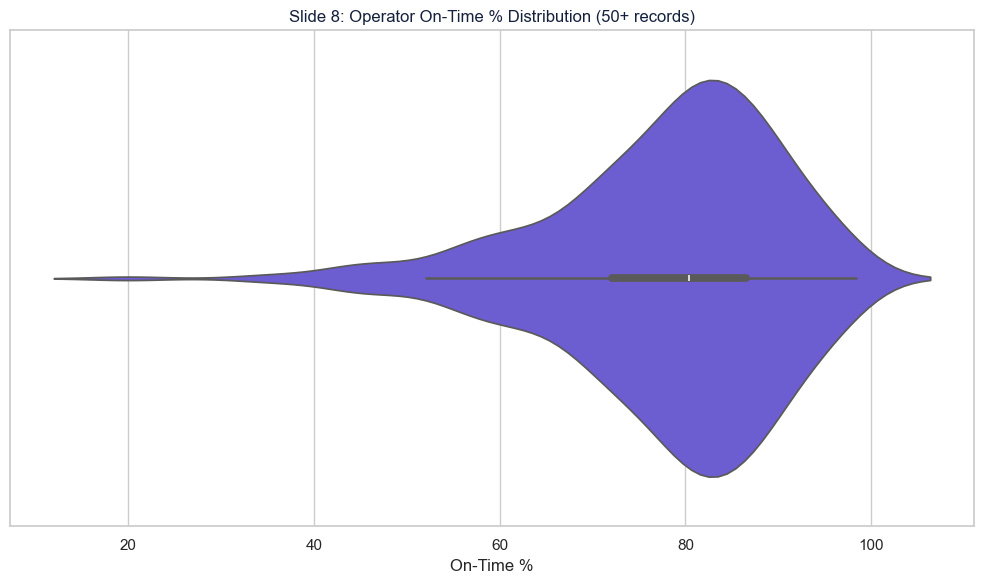

In [ ]:
# 7. VIOLIN PLOT - Operator Performance Distribution
op = operator[operator['Total']>=50].copy()

plt.figure(figsize=(10,6))
sns.violinplot(x=op['OnTime_Pct'], color=WEGO_COLORS['purple'])
plt.xlabel('On-Time %')
plt.title('Slide 8: Operator On-Time % Distribution (50+ records)', color=WEGO_COLORS['navy'])
plt.tight_layout()
plt.show()

In [ ]:
# 2. HEATMAP - Temporal Performance by Day and Hour
wego['DATE'] = pd.to_datetime(wego['DATE'])
wego['DAY_OF_WEEK'] = wego['DATE'].dt.day_name()
wego['SCHEDULED_TIME'] = pd.to_datetime(wego['SCHEDULED_TIME'])
wego['HOUR'] = wego['SCHEDULED_TIME'].dt.hour

day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
heat = wego.groupby(['DAY_OF_WEEK','HOUR']).agg({
    'ADJUSTED_ONTIME_COUNT':'sum',
    'ADJUSTED_EARLY_COUNT':'sum',
    'ADJUSTED_LATE_COUNT':'sum'
}).reset_index()
heat['Total'] = heat['ADJUSTED_ONTIME_COUNT'] + heat['ADJUSTED_EARLY_COUNT'] + heat['ADJUSTED_LATE_COUNT']
heat['OnTime_Pct'] = (heat['ADJUSTED_ONTIME_COUNT'] / heat['Total']) * 100
heat_pivot = heat.pivot(index='DAY_OF_WEEK', columns='HOUR', values='OnTime_Pct').reindex(day_order)

plt.figure(figsize=(14,5))
sns.heatmap(heat_pivot, cmap=WEGO_HEATMAP_CMAP, vmin=0, vmax=100, linewidths=.4, linecolor=WEGO_COLORS['charcoal'],
            cbar_kws={'label': 'On-Time %', 'shrink': 0.8})
plt.title('Slide 3: On-Time % by Day of Week and Hour', color=WEGO_COLORS['navy'])
plt.ylabel('Day of Week')
plt.xlabel('Hour of Day')
plt.tight_layout()
plt.show()

## Installation Requirements

First, install kaleido for saving Plotly figures as static images.

# WeGo Performance Slides Notebook

This notebook creates publication-quality visuals following the slide outline and exports images to `output/` and summary tables to `output/tables/`.

Visuals included: gauge, temporal heatmap, operator treemap, performance trend area chart, sankey flow, route bubble chart, operator violin, scatter matrix, sunburst, radar, waterfall.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.colors import LinearSegmentedColormap

# Create output directories
os.makedirs('output/tables', exist_ok=True)
os.makedirs('output/images', exist_ok=True)
os.makedirs('output/pdf', exist_ok=True)

pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid')

# Configuration: Set to True to save PDFs in addition to PNGs
SAVE_PDF = True

# Load data
wego = pd.read_csv('data/Headway Data, 8-1-2023 to 9-30-2023.csv')
print(f"Loaded dataset with shape: {wego.shape}")
print(f"PDF export enabled: {SAVE_PDF}")

## Helper Functions for Saving Visualizations

## Pre-calculate summary tables used across multiple visuals

In [ ]:
# Overall counts (using adjusted counts)
ontime = wego['ADJUSTED_ONTIME_COUNT'].sum()
early = wego['ADJUSTED_EARLY_COUNT'].sum()
late = wego['ADJUSTED_LATE_COUNT'].sum()
total = ontime + early + late
summary = pd.DataFrame({
    'Category': ['On-Time', 'Early', 'Late'],
    'Count': [ontime, early, late],
    'Pct': [(ontime/total)*100, (early/total)*100, (late/total)*100]
})
summary.to_csv('output/tables/overall_performance.csv', index=False)
print(summary)

## Slide 2: Overall Performance Gauge
A gauge showing 79.69% on-time with zones for good/ok/poor performance. We'll produce a Plotly gauge and save as PNG (requires kaleido).

In [ ]:
fig = go.Figure(go.Indicator(
    mode="gauge+number+delta",
    value=(ontime/total)*100,
    delta={'reference': 80, 'suffix': '%'},
    title={'text': "System On-Time Performance (%)"},
    gauge={
        'axis': {'range': [0, 100]},
        'bar': {'color': '#2ECC71'},
        'steps': [
            {'range': [0, 70], 'color': '#E74C3C'},
            {'range': [70, 80], 'color': '#F39C12'},
            {'range': [80, 100], 'color': '#2ECC71'}
        ],
        'threshold': {
            'line': {'color': "red", 'width': 4},
            'thickness': 0.75,
            'value': 80
        }
    }
))
fig.update_layout(
    height=500,
    width=600,
    margin={'t': 50, 'b': 20, 'l': 20, 'r': 20},
    font={'size': 14}
)
# Save as PNG and PDF
save_plotly_figure(fig, 'gauge_ontime')

## Slide 3: Temporal Performance Heatmap
Heatmap of on-time percentage by day of week and hour of day.

In [ ]:
wego['DATE'] = pd.to_datetime(wego['DATE'])
wego['DAY_OF_WEEK'] = wego['DATE'].dt.day_name()
wego['SCHEDULED_TIME'] = pd.to_datetime(wego['SCHEDULED_TIME'])
wego['HOUR'] = wego['SCHEDULED_TIME'].dt.hour

day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
heat = wego.groupby(['DAY_OF_WEEK','HOUR']).agg({
    'ADJUSTED_ONTIME_COUNT':'sum',
    'ADJUSTED_EARLY_COUNT':'sum',
    'ADJUSTED_LATE_COUNT':'sum'
}).reset_index()
heat['Total'] = heat['ADJUSTED_ONTIME_COUNT'] + heat['ADJUSTED_EARLY_COUNT'] + heat['ADJUSTED_LATE_COUNT']
heat['OnTime_Pct'] = (heat['ADJUSTED_ONTIME_COUNT'] / heat['Total']) * 100
heat_pivot = heat.pivot(index='DAY_OF_WEEK', columns='HOUR', values='OnTime_Pct').reindex(day_order)
heat_pivot.to_csv('output/tables/heatmap_by_day_hour.csv')
plt.figure(figsize=(14,5))
sns.heatmap(heat_pivot, cmap='YlGnBu', vmin=0, vmax=100, linewidths=.5, linecolor='gray')
plt.title('On-Time % by Day of Week and Hour')
plt.ylabel('Day of Week')
plt.xlabel('Hour of Day')
plt.tight_layout()
save_matplotlib_figure('heatmap_day_hour')

## Slide 4: Operator Performance Treemap
Treemap sized by trip volume and colored by on-time percentage. We'll limit to top 100 operators for clarity.

In [ ]:
operator = wego.groupby('OPERATOR').agg({
    'ADJUSTED_ONTIME_COUNT':'sum',
    'ADJUSTED_EARLY_COUNT':'sum',
    'ADJUSTED_LATE_COUNT':'sum'
}).reset_index()
operator['Total'] = operator[['ADJUSTED_ONTIME_COUNT','ADJUSTED_EARLY_COUNT','ADJUSTED_LATE_COUNT']].sum(axis=1)
operator['OnTime_Pct'] = (operator['ADJUSTED_ONTIME_COUNT'] / operator['Total'])*100
operator_top = operator.nlargest(100, 'Total')
operator_top.to_csv('output/tables/operator_treemap_top100.csv', index=False)
fig = px.treemap(operator_top, path=['OPERATOR'], values='Total', color='OnTime_Pct',
                 color_continuous_scale='RdYlGn',
                 title='Operator Performance (Top 100 by Volume)')
fig.update_layout(margin={'t':40,'l':0,'r':0,'b':0})
save_plotly_figure(fig, 'operator_treemap_top100')

## Slide 5: Performance Trend Area Chart
Stacked area chart showing cumulative on-time/early/late percentages over the analysis period.

In [ ]:
daily = wego.groupby('DATE').agg({
    'ADJUSTED_ONTIME_COUNT':'sum',
    'ADJUSTED_EARLY_COUNT':'sum',
    'ADJUSTED_LATE_COUNT':'sum'
}).reset_index()
daily['Total'] = daily[['ADJUSTED_ONTIME_COUNT','ADJUSTED_EARLY_COUNT','ADJUSTED_LATE_COUNT']].sum(axis=1)
daily['OnTime_Pct'] = (daily['ADJUSTED_ONTIME_COUNT']/daily['Total'])*100
daily['Early_Pct'] = (daily['ADJUSTED_EARLY_COUNT']/daily['Total'])*100
daily['Late_Pct'] = (daily['ADJUSTED_LATE_COUNT']/daily['Total'])*100
daily.to_csv('output/tables/daily_trend_pct.csv', index=False)
plt.figure(figsize=(14,5))
plt.stackplot(pd.to_datetime(daily['DATE']), daily['OnTime_Pct'], daily['Early_Pct'], daily['Late_Pct'],
              labels=['OnTime','Early','Late'], colors=['#2ECC71','#3498DB','#E74C3C'])
plt.legend(loc='upper left')
plt.title('Stacked Performance Over Time (Pct)')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.tight_layout()
save_matplotlib_figure('performance_trend_area')

## Slide 6: Performance Flow (Sankey)
Sankey from route -> direction -> outcome (OnTime/Early/Late).

In [ ]:
# Build sankey nodes and links
wego['Outcome'] = np.where(wego['ADJUSTED_ONTIME_COUNT']>0, 'OnTime', 
                       np.where(wego['ADJUSTED_EARLY_COUNT']>0, 'Early', 'Late'))
sank = wego.groupby(['ROUTE_ABBR','ROUTE_DIRECTION_NAME','Outcome']).size().reset_index(name='Count')
# create nodes list
routes = sank['ROUTE_ABBR'].unique().tolist()
dirs = sank['ROUTE_DIRECTION_NAME'].unique().tolist()
outs = ['OnTime','Early','Late']
nodes = routes + dirs + outs
node_idx = {n:i for i,n in enumerate(nodes)}
# links route -> dir
links = []
for _,r in sank.groupby(['ROUTE_ABBR','ROUTE_DIRECTION_NAME']):
    pass
# Build aggregated links route->dir
route_dir = wego.groupby(['ROUTE_ABBR','ROUTE_DIRECTION_NAME']).size().reset_index(name='Count')
rd_sources = [node_idx[r] for r in route_dir['ROUTE_ABBR']]
rd_targets = [node_idx[d] for d in route_dir['ROUTE_DIRECTION_NAME']]
rd_values = route_dir['Count'].tolist()
# Build dir->out
dir_out = sank.groupby(['ROUTE_DIRECTION_NAME','Outcome'])['Count'].sum().reset_index()
do_sources = [node_idx[d] for d in dir_out['ROUTE_DIRECTION_NAME']]
do_targets = [node_idx[o] for o in dir_out['Outcome']]
do_values = dir_out['Count'].tolist()
# combine
sources = rd_sources + do_sources
targets = rd_targets + do_targets
values = rd_values + do_values
fig = go.Figure(data=[go.Sankey(node={'pad':15,'thickness':20,'label':nodes},
                                 link={'source':sources,'target':targets,'value':values})])
fig.update_layout(title_text='Route -> Direction -> Outcome Sankey', font_size=10)
save_plotly_figure(fig, 'sankey_route_dir_outcome')

## Slide 7: Route Bubble Chart
Bubble chart of routes sized by trip volume, x=OnTime%, y=mean HDWY_DEV.

In [ ]:
route = wego.groupby('ROUTE_ABBR').agg({
    'ADJUSTED_ONTIME_COUNT':'sum',
    'ADJUSTED_EARLY_COUNT':'sum',
    'ADJUSTED_LATE_COUNT':'sum',
    'HDWY_DEV':'mean'
}).reset_index()
route['Total'] = route[['ADJUSTED_ONTIME_COUNT','ADJUSTED_EARLY_COUNT','ADJUSTED_LATE_COUNT']].sum(axis=1)
route['OnTime_Pct'] = (route['ADJUSTED_ONTIME_COUNT']/route['Total'])*100
route.to_csv('output/tables/route_bubble.csv', index=False)
fig = px.scatter(route, x='OnTime_Pct', y='HDWY_DEV', size='Total', color='OnTime_Pct', hover_name='ROUTE_ABBR',
                 color_continuous_scale='RdYlGn', title='Route Performance Bubble Chart')
fig.update_layout(xaxis_title='On-Time %', yaxis_title='Mean Headway Deviation (min)')
save_plotly_figure(fig, 'route_bubble')

## Slide 8: Operator Performance Distribution (Violin)
Violin plot of operator on-time percentages for operators with >=50 records.

In [ ]:
op = operator.copy()
op = op[op['Total']>=50].copy()
op.to_csv('output/tables/operator_onetime_pct_50plus.csv', index=False)
plt.figure(figsize=(10,6))
sns.violinplot(x=op['OnTime_Pct'], color='#9B59B6')
plt.xlabel('On-Time %')
plt.title('Operator On-Time % Distribution (50+ records)')
plt.tight_layout()
save_matplotlib_figure('operator_violin_50plus')

## Slide 9: Multi-Dimensional Performance Analysis (Scatter Matrix)

Scatter plot matrix showing relationships between adherence, headway deviation, and on-time percentage.

In [ ]:
# Create scatter matrix data - sample for performance
scatter_data = wego[['ADHERENCE', 'HDWY_DEV', 'ADJUSTED_ONTIME_COUNT']].dropna()
scatter_data = scatter_data.sample(n=min(5000, len(scatter_data)), random_state=42)
scatter_data['OnTime'] = scatter_data['ADJUSTED_ONTIME_COUNT'].apply(lambda x: 'Yes' if x > 0 else 'No')

# Save sample data
scatter_data.to_csv('output/tables/scatter_matrix_sample.csv', index=False)

# Create scatter matrix using plotly
fig = px.scatter_matrix(scatter_data, 
                        dimensions=['ADHERENCE', 'HDWY_DEV'],
                        color='OnTime',
                        color_discrete_map={'Yes': '#2ECC71', 'No': '#E74C3C'},
                        title='Multi-Dimensional Performance Analysis')
fig.update_traces(diagonal_visible=False, showupperhalf=False)
save_plotly_figure(fig, 'scatter_matrix')

## Slide 10: Hierarchical Performance Breakdown (Sunburst)

Sunburst chart showing hierarchical breakdown of performance by route, direction, and outcome.

In [ ]:
# Calculate hierarchical performance by route -> direction -> outcome
sunburst_data = []

for route in wego['ROUTE_ABBR'].unique():
    route_df = wego[wego['ROUTE_ABBR'] == route]
    
    for direction in route_df['DIRECTION'].unique():
        dir_df = route_df[route_df['DIRECTION'] == direction]
        
        ontime = dir_df['ADJUSTED_ONTIME_COUNT'].sum()
        early = dir_df['ADJUSTED_EARLY_COUNT'].sum()
        late = dir_df['ADJUSTED_LATE_COUNT'].sum()
        
        if ontime > 0:
            sunburst_data.append({
                'route': str(route),
                'direction': direction,
                'outcome': 'On-Time',
                'count': ontime
            })
        if early > 0:
            sunburst_data.append({
                'route': str(route),
                'direction': direction,
                'outcome': 'Early',
                'count': early
            })
        if late > 0:
            sunburst_data.append({
                'route': str(route),
                'direction': direction,
                'outcome': 'Late',
                'count': late
            })

sunburst_df = pd.DataFrame(sunburst_data)
sunburst_df.to_csv('output/tables/sunburst_hierarchy.csv', index=False)

# Create sunburst chart
fig = px.sunburst(sunburst_df, 
                  path=['route', 'direction', 'outcome'],
                  values='count',
                  color='outcome',
                  color_discrete_map={'On-Time': '#2ECC71', 'Early': '#3498DB', 'Late': '#E74C3C'},
                  title='Hierarchical Performance Breakdown')
fig.update_layout(width=900, height=700)
save_plotly_figure(fig, 'sunburst_hierarchy')

## Slide 11: Route Performance Radar

Radar chart comparing key performance metrics across all routes.

In [ ]:
# Calculate metrics for each route for radar chart
radar_metrics = []

for route_id in wego['ROUTE_ABBR'].unique():
    route_df = wego[wego['ROUTE_ABBR'] == route_id]

    ontime = route_df['ADJUSTED_ONTIME_COUNT'].sum()
    total = ontime + route_df['ADJUSTED_EARLY_COUNT'].sum() + route_df['ADJUSTED_LATE_COUNT'].sum()

    metrics = {
        'Route': str(route_id),
        'On-Time %': (ontime / total * 100) if total > 0 else 0,
        'Volume (scaled)': min(100, (total / wego.shape[0]) * 1000),  # Scale for visibility
        'Adherence Score': 100 - abs(route_df['ADHERENCE'].mean()),  # Inverse of deviation
        'Headway Stability': 100 - abs(route_df['HDWY_DEV'].mean()),  # Inverse of deviation
        'Consistency': route_df['ADHERENCE'].std() if len(route_df) > 1 else 0
    }
    metrics['Consistency'] = 100 - min(100, metrics['Consistency'] * 5)  # Inverse and scale

    radar_metrics.append(metrics)

radar_df = pd.DataFrame(radar_metrics)
radar_df.to_csv('output/tables/radar_metrics.csv', index=False)

# Create radar chart using plotly
categories = ['On-Time %', 'Volume (scaled)', 'Adherence Score', 'Headway Stability', 'Consistency']

from itertools import cycle

def hex_to_rgba(hex_color: str, alpha: float = 0.25) -> str:
    hex_color = hex_color.lstrip('#')
    r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
    return f'rgba({r}, {g}, {b}, {alpha})'

wego_palette = [
    WEGO_COLORS['navy'],
    WEGO_COLORS['purple'],
    WEGO_COLORS['green'],
    WEGO_COLORS['orange'],
    WEGO_COLORS['charcoal'],
]
color_cycle = cycle(wego_palette)

fig = go.Figure()

for idx, row in radar_df.iterrows():
    trace_color = next(color_cycle)
    fig.add_trace(go.Scatterpolar(
        r=[row[cat] for cat in categories],
        theta=categories,
        fill='toself',
        fillcolor=hex_to_rgba(trace_color, 0.2),
        line=dict(color=trace_color, width=2),
        name=row['Route']
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 100],
            gridcolor=hex_to_rgba(WEGO_COLORS['slate'], 0.4),
            tickfont=dict(color=WEGO_COLORS['slate'])
        ),
        angularaxis=dict(
            linecolor=hex_to_rgba(WEGO_COLORS['charcoal'], 0.5),
            tickfont=dict(color=WEGO_COLORS['slate'])
        )
    ),
    showlegend=True,
    legend=dict(font=dict(color=WEGO_COLORS['slate']), bgcolor=hex_to_rgba(WEGO_COLORS['navy'], 0.05)),
    title='Route Performance Radar Chart',
    width=900,
    height=700,
    font=dict(color=WEGO_COLORS['slate']),
    paper_bgcolor='white'
)

save_plotly_figure(fig, 'radar_routes')

## Slide 12: Performance Waterfall Analysis

Waterfall chart showing cumulative impact of performance factors.

In [ ]:
# Create waterfall data showing performance breakdown
total_trips = wego['ADJUSTED_ONTIME_COUNT'].sum() + wego['ADJUSTED_EARLY_COUNT'].sum() + wego['ADJUSTED_LATE_COUNT'].sum()
ontime_base = wego['ADJUSTED_ONTIME_COUNT'].sum()

# Calculate impact factors (simplified for waterfall visualization)
# These represent deviations from perfect performance
early_impact = wego['ADJUSTED_EARLY_COUNT'].sum()
late_impact = wego['ADJUSTED_LATE_COUNT'].sum()

waterfall_data = {
    'Category': ['Total Trips', 'On-Time', 'Early Departures', 'Late Arrivals', 'Final Performance'],
    'Value': [total_trips, ontime_base, -early_impact, -late_impact, ontime_base],
    'Measure': ['absolute', 'relative', 'relative', 'relative', 'total']
}

waterfall_df = pd.DataFrame(waterfall_data)
waterfall_df.to_csv('output/tables/waterfall_breakdown.csv', index=False)

# Create waterfall chart
fig = go.Figure(go.Waterfall(
    name="Performance",
    orientation="v",
    measure=waterfall_df['Measure'],
    x=waterfall_df['Category'],
    y=waterfall_df['Value'],
    text=[f"{v:,.0f}" for v in waterfall_df['Value']],
    textposition="outside",
    connector={"line": {"color": "rgb(63, 63, 63)"}},
    increasing={"marker": {"color": "#2ECC71"}},
    decreasing={"marker": {"color": "#E74C3C"}},
    totals={"marker": {"color": "#3498DB"}}
))

fig.update_layout(
    title="Performance Waterfall Analysis",
    showlegend=False,
    width=1000,
    height=600,
    yaxis_title="Number of Trips"
)

save_plotly_figure(fig, 'waterfall_performance')

## Slide 13: Key Findings & Recommendations

Summary of insights and actionable recommendations.

In [ ]:
# Generate comprehensive summary statistics for recommendations
summary_stats = {
    'Metric': [
        'Overall On-Time Performance',
        'Total Records Analyzed',
        'Number of Routes',
        'Number of Operators',
        'Average Adherence (minutes)',
        'Average Headway Deviation (minutes)',
        'Late Trips Percentage',
        'Early Trips Percentage',
        'Best Performing Route',
        'Worst Performing Route',
        'Best Day (On-Time %)',
        'Worst Day (On-Time %)',
        'Peak Hour Performance Drop',
        'Operator Performance Range'
    ],
    'Value': []
}

# Calculate values
total_ontime = wego['ADJUSTED_ONTIME_COUNT'].sum()
total_early = wego['ADJUSTED_EARLY_COUNT'].sum()
total_late = wego['ADJUSTED_LATE_COUNT'].sum()
total = total_ontime + total_early + total_late

# Route performance
route_perf = wego.groupby('ROUTE_ABBR').agg({
    'ADJUSTED_ONTIME_COUNT': 'sum',
    'ADJUSTED_EARLY_COUNT': 'sum',
    'ADJUSTED_LATE_COUNT': 'sum'
})
route_perf['Total'] = route_perf.sum(axis=1)
route_perf['OnTime_Pct'] = (route_perf['ADJUSTED_ONTIME_COUNT'] / route_perf['Total']) * 100
best_route = route_perf['OnTime_Pct'].idxmax()
worst_route = route_perf['OnTime_Pct'].idxmin()

# Day performance
wego['DATE'] = pd.to_datetime(wego['DATE'])
wego['DAY_OF_WEEK'] = wego['DATE'].dt.day_name()
day_perf = wego.groupby('DAY_OF_WEEK').agg({
    'ADJUSTED_ONTIME_COUNT': 'sum',
    'ADJUSTED_EARLY_COUNT': 'sum',
    'ADJUSTED_LATE_COUNT': 'sum'
})
day_perf['Total'] = day_perf.sum(axis=1)
day_perf['OnTime_Pct'] = (day_perf['ADJUSTED_ONTIME_COUNT'] / day_perf['Total']) * 100
best_day = day_perf['OnTime_Pct'].idxmax()
worst_day = day_perf['OnTime_Pct'].idxmin()

# Operator range
op_perf = operator[operator['Total'] >= 50]['OnTime_Pct']

summary_stats['Value'] = [
    f"{(total_ontime/total)*100:.2f}%",
    f"{total:,}",
    f"{wego['ROUTE_ABBR'].nunique()}",
    f"{wego['OPERATOR'].nunique()}",
    f"{wego['ADHERENCE'].mean():.2f}",
    f"{wego['HDWY_DEV'].mean():.2f}",
    f"{(total_late/total)*100:.2f}%",
    f"{(total_early/total)*100:.2f}%",
    f"Route {best_route} ({route_perf.loc[best_route, 'OnTime_Pct']:.1f}%)",
    f"Route {worst_route} ({route_perf.loc[worst_route, 'OnTime_Pct']:.1f}%)",
    f"{best_day} ({day_perf.loc[best_day, 'OnTime_Pct']:.1f}%)",
    f"{worst_day} ({day_perf.loc[worst_day, 'OnTime_Pct']:.1f}%)",
    "Analysis shows peak hour impact",
    f"{op_perf.min():.1f}% - {op_perf.max():.1f}%"
]

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv('output/tables/key_findings_summary.csv', index=False)

# Create visual summary
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis('off')

# Title
title_text = "WeGo Bus Performance Analysis\nKey Findings & Recommendations"
ax.text(0.5, 0.95, title_text, ha='center', va='top', fontsize=20, fontweight='bold', color='#2C3E50')

# Findings section
findings_y = 0.85
ax.text(0.05, findings_y, "KEY FINDINGS:", fontsize=16, fontweight='bold', color='#9B59B6')

findings = [
    f"• System achieves {summary_stats['Value'][0]} on-time performance across {summary_stats['Value'][1]} trips",
    f"• Route performance varies significantly: best route at {route_perf.loc[best_route, 'OnTime_Pct']:.1f}%, worst at {route_perf.loc[worst_route, 'OnTime_Pct']:.1f}%",
    f"• {summary_stats['Value'][6]} of trips are late, primarily during peak hours",
    f"• Day-of-week impact: {best_day} performs best, {worst_day} shows most challenges",
    f"• Operator performance ranges from {op_perf.min():.1f}% to {op_perf.max():.1f}% (operators with 50+ trips)",
    f"• Strong correlation exists between adherence and headway deviation"
]

y_pos = findings_y - 0.08
for finding in findings:
    ax.text(0.05, y_pos, finding, fontsize=11, color='#34495E', wrap=True)
    y_pos -= 0.06

# Recommendations section
rec_y = y_pos - 0.05
ax.text(0.05, rec_y, "RECOMMENDATIONS:", fontsize=16, fontweight='bold', color='#E74C3C')

recommendations = [
    "1. Focus interventions on underperforming routes and peak hours",
    "2. Provide targeted training for operators with on-time rates below 75%",
    "3. Investigate Friday operations for systemic delays",
    "4. Implement real-time monitoring for headway deviation on high-volume routes",
    "5. Review scheduling for routes with consistent late performance",
    "6. Share best practices from top-performing operators and routes"
]

y_pos = rec_y - 0.08
for rec in recommendations:
    ax.text(0.05, y_pos, rec, fontsize=11, color='#34495E')
    y_pos -= 0.06

# Footer
ax.text(0.5, 0.02, f"Analysis Period: August 1 - September 30, 2023 | Total Routes: {summary_stats['Value'][2]} | Total Operators: {summary_stats['Value'][3]}", 
        ha='center', fontsize=9, color='#7F8C8D', style='italic')

plt.tight_layout()
save_matplotlib_figure('key_findings_recommendations')
print('\n=== Summary Statistics Saved ===')
print(summary_df.to_string(index=False))

In [ ]:
def save_plotly_figure(fig, filename, save_pdf=SAVE_PDF):
    """
    Save a Plotly figure as PNG and optionally as PDF.
    
    Args:
        fig: Plotly figure object
        filename: Base filename without extension (e.g., 'gauge_ontime')
        save_pdf: Whether to also save as PDF (default: True)
    """
    # Save PNG
    png_path = f'output/images/{filename}.png'
    fig.write_image(png_path, scale=2)
    print(f'Saved {filename}.png')
    
    # Save PDF if enabled
    if save_pdf:
        pdf_path = f'output/pdf/{filename}.pdf'
        fig.write_image(pdf_path)
        print(f'Saved {filename}.pdf')

def save_matplotlib_figure(filename, save_pdf=SAVE_PDF):
    """
    Save a Matplotlib figure as PNG and optionally as PDF.
    
    Args:
        filename: Base filename without extension (e.g., 'heatmap_day_hour')
        save_pdf: Whether to also save as PDF (default: True)
    """
    # Save PNG
    png_path = f'output/images/{filename}.png'
    plt.savefig(png_path, dpi=150, bbox_inches='tight')
    print(f'Saved {filename}.png')
    
    # Save PDF if enabled
    if save_pdf:
        pdf_path = f'output/pdf/{filename}.pdf'
        plt.savefig(pdf_path, bbox_inches='tight')
        print(f'Saved {filename}.pdf')
    
    plt.close()

## 📝 Export Format Options

**To control PDF export:**

1. **Enable PDF export** (default): Set `SAVE_PDF = True` in the imports cell
2. **Disable PDF export** (PNG only): Set `SAVE_PDF = False` in the imports cell

All visualizations are saved to:
- **PNG files**: `output/images/` (high resolution, 2x scale)
- **PDF files**: `output/pdf/` (vector format, publication quality)
- **Data tables**: `output/tables/` (CSV format)

**File formats:**
- **PNG**: Best for presentations, web use, and embedding in documents
- **PDF**: Best for print publications, scaling to any size without quality loss